**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### All code for this project can be found in vehicle_detection.py

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.



The code for this step is contained at line 25 from the vehicle_detection.py in the function get_hog_features().

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

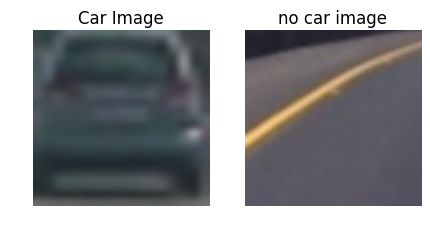

In [1]:
import vehicle_detection as vd
import matplotlib.pyplot as plt
%matplotlib inline
car, non_car = vd.get_random_car_and_non_car()
fig = plt.figure(figsize=(5, 5))
plt.subplot(121)
plt.imshow(car)
plt.title('Car Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(non_car)
plt.title('no car image')
plt.axis('off')
plt.show()

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  and settled on the following parameters (since they gave me the best model performance results approx. 98.7% accuracy):
    * color space = Y&U from YUV and H&S from HSV
    * orientations = 8
    * pixels_per_cell = 8
    * cells_per_block = 2

Here is an example of the HOG parameters of an image:

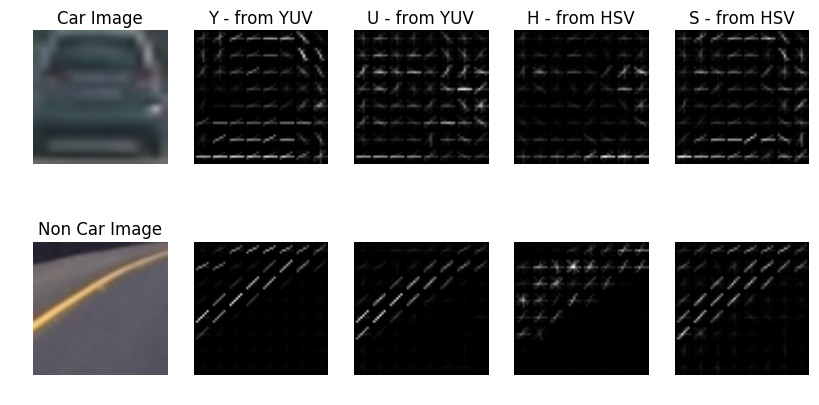

In [10]:
car, non_car = vd.get_random_car_and_non_car()
from skimage.feature import hog
import cv2
import numpy as np
car_yuv = cv2.cvtColor(car, cv2.COLOR_RGB2YUV)
features, car_yuv_1 = hog(car_yuv[:,:,0], orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2),
                          transform_sqrt=True, visualise=True, feature_vector=True)
features, car_yuv_2 = hog(car_yuv[:,:,1], orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2),
                          transform_sqrt=True, visualise=True, feature_vector=True)
car_hsv = cv2.cvtColor(car, cv2.COLOR_RGB2HSV)
features, car_hsv_1 = hog(car_hsv[:,:,0], orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2),
                          transform_sqrt=True, visualise=True, feature_vector=True)
features, car_hsv_2 = hog(car_hsv[:,:,1], orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2),
                          transform_sqrt=True, visualise=True, feature_vector=True)

non_car_yuv = cv2.cvtColor(non_car, cv2.COLOR_RGB2YUV)
features, non_car_yuv_1 = hog(non_car_yuv[:,:,0], orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2),
                          transform_sqrt=True, visualise=True, feature_vector=True)
features, non_car_yuv_2 = hog(non_car_yuv[:,:,1], orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2),
                          transform_sqrt=True, visualise=True, feature_vector=True)
non_car_hsv = cv2.cvtColor(non_car, cv2.COLOR_RGB2HSV)
features, non_car_hsv_1 = hog(non_car_hsv[:,:,0], orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2),
                          transform_sqrt=True, visualise=True, feature_vector=True)
features, non_car_hsv_2 = hog(non_car_hsv[:,:,1], orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2),
                          transform_sqrt=True, visualise=True, feature_vector=True)
fig = plt.figure(figsize=(10,5))
plt.subplot(251)
plt.imshow(car,cmap='gray')
plt.title('Car Image')
plt.axis('off')
plt.subplot(252)
plt.imshow(car_yuv_1,cmap='gray')
plt.title('Y - from YUV')
plt.axis('off')
plt.subplot(253)
plt.imshow(car_yuv_2,cmap='gray')
plt.title('U - from YUV')
plt.axis('off')
plt.subplot(254)
plt.imshow(car_hsv_1,cmap='gray')
plt.title('H - from HSV')
plt.axis('off')
plt.subplot(255)
plt.imshow(car_hsv_2,cmap='gray')
plt.title('S - from HSV')
plt.axis('off')
plt.subplot(256)
plt.imshow(non_car,cmap='gray')
plt.title('Non Car Image')
plt.axis('off')
plt.subplot(257)
plt.imshow(non_car_yuv_1,cmap='gray')
plt.axis('off')
plt.subplot(258)
plt.imshow(non_car_yuv_2,cmap='gray')
plt.axis('off')
plt.subplot(259)
plt.imshow(non_car_hsv_1,cmap='gray')
plt.axis('off')
plt.subplot(2,5,10)
plt.imshow(non_car_hsv_2,cmap='gray')
plt.axis('off')
plt.show()

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters of all features (at one point I had more than 300 different parameter combinations) and tried to see which one will give me the best outcome (visually and model performance), I settled on my parameters based on simplicity along with a great model accuracy score (approximately 98.7% accuracy).

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using HOG features using all 4 layers from every image (HS and YU), the model training is in line 117 from the vehicle_detection.py in the function get_model().

---

### Pipeline:

my model for detecting a vehicle in a frame works as follows:

    1) Get HOG features for the image. 
    
    2) Create a new binary image (of all zeros) the size of the image. 
    
    3) Run windows of the image through the SVM classifier (see more in the Sliding Window search section).
    
    4) For every window which was detected as a vehicle - add 1 to all pixels within the window frame on the binary image.
    
    5) Add it to a queue of binary frames, and use the full stack of binary images within the queue as the image (with some logic to remove outliers)
    
    6) Create boundaries - (this step involved combining the vehicles from the new frame and old frame)
    
    
Here are images for each of the steps:

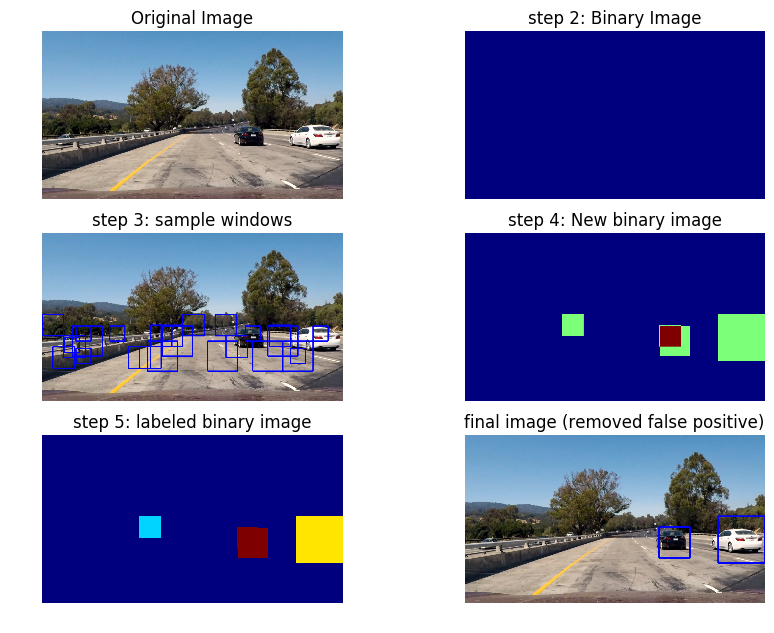

In [29]:
from random import shuffle
from scipy.ndimage.measurements import label
image = plt.imread('.\\test_images\\test1.jpg')
bbinary_image = np.zeros_like(image[:,:,0])

windows = vd.standard_windows[:]
shuffle(windows)
boxes_image = np.copy(image)
boxes_image = vd.draw_boxes(boxes_image, windows[:25], color=(0, 0, 255), thick=3)
jpg_image = image.astype(np.float32)/255
hot_windows,binary_image = vd.search_windows(jpg_image, windows, vd.svc, vd.X_scaler, color_space='RGB', 
            spatial_size=(16, 16), hist_bins=16, orient=8, pix_per_cell=8, cell_per_block=2,
            hog_channel="ALL", spatial_feat=False, hist_feat=False, hog_feat=True) 
binary_image = binary_image.astype(int)
labeled_array, num_features = label(binary_image)
bboxes = vd.created_bboxes(labeled_array, num_features)
cp_image = np.copy(image)
final_image =  vd.draw_boxes(cp_image, bboxes, color=(0, 0, 255), thick=6)

fig = plt.figure(figsize=(10,10))
plt.subplot(421)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')
plt.subplot(422)
plt.title('step 2: Binary Image')
plt.imshow(bbinary_image)
plt.axis('off')
plt.subplot(423)
plt.title('step 3: sample windows')
plt.imshow(boxes_image)
plt.axis('off')
plt.subplot(424)
plt.title('step 4: New binary image')
plt.imshow(binary_image)
plt.axis('off')
plt.subplot(425)
plt.title('step 5: labeled binary image')
plt.imshow(labeled_array)
plt.axis('off')
plt.subplot(426)
plt.title('final image (removed false positive)')
plt.imshow(final_image)
plt.axis('off')
plt.show()

---




### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

sliding window search was done in lines 415 - 421 from the vehicle_detection.py file.

I tried various combinations of scales and overlap windows, and ended up using 5 sizes:

   92x92, 128x128, and 192x192 with an overlap window of 50%
   
   64x64 with an overlap window of 50%
   
   200x200 with an overlap window of 90%


#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to try to minimize false positives and reliably detect cars?

Ultimately I searched on 4-channel HOG features, which provided a nice result, I also used a queue of previous frames in order to remove false positives. Here are some example images:

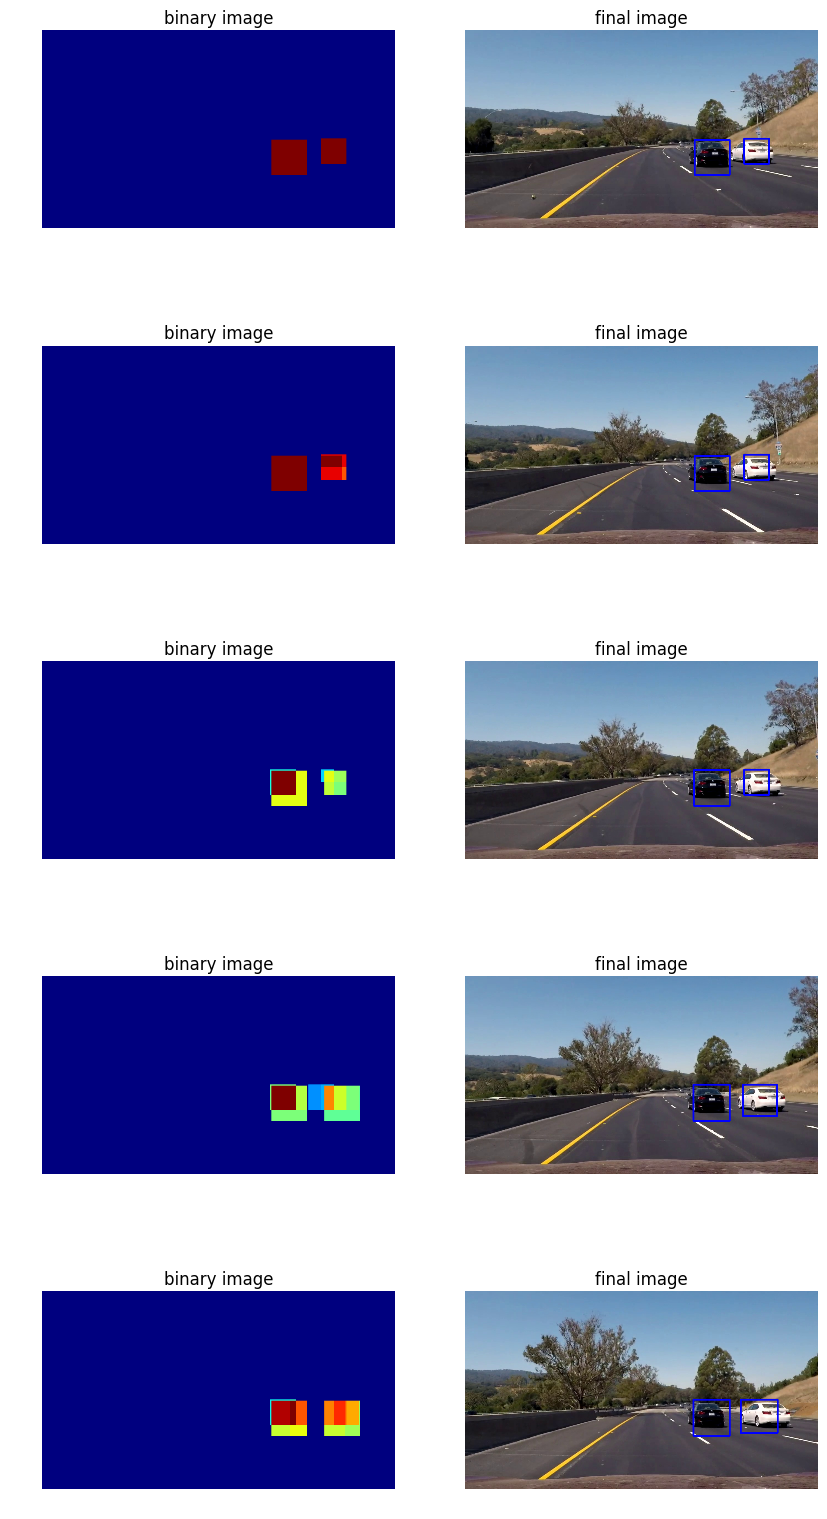

In [52]:
from collections import deque
fig = plt.figure(figsize=(10,40))
j = 1
queue = deque([], 15)  
vehicle_array = vd.Vehicle_Array()
for  i in range(50):
    image = plt.imread('.\\test_vid\\img_'+str(i)+'.jpg')
    jpg_image = image.astype(np.float32)/255
    hot_windows,binary_image = vd.search_windows(jpg_image, vd.standard_windows, vd.svc, vd.X_scaler, color_space='RGB', 
                        spatial_size=(16, 16), hist_bins=16, orient=8, pix_per_cell=8, cell_per_block=2,
                        hog_channel="ALL", spatial_feat=False, hist_feat=False, hog_feat=True) 
    binary_image = binary_image.astype(int)
    queue.appendleft(binary_image)
    comb_binary_image = np.zeros_like(image[:,:,0]).astype(int)
    for k in queue:
        comb_binary_image += k
    comb_binary_image[comb_binary_image < len(queue) / 2 ] = 0
    labeled_array, num_features = label(comb_binary_image)
    bboxes = vd.created_bboxes(labeled_array, num_features)
    windows = vd.get_bboxes(bboxes, vehicle_array)
    cp_image = np.copy(image)
    detected_image = vd.draw_boxes(cp_image, windows, color=(0, 0, 255), thick=6)
    if i % 10 == 0:
        plt.subplot(10,2,j)
        plt.imshow(comb_binary_image)
        plt.title('binary image')
        plt.axis('off')
        j += 1
        plt.subplot(10,2,j)
        plt.imshow(detected_image)
        plt.title('final image')
        plt.axis('off')
        j+= 1
plt.show()

---

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](https://youtu.be/_-8ovpAVmEM)

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

Filtering was done in a couple of places

   * I filtered the x and y axis (one when searching for windows and one later).

   * I removed all pixels in the queue which weren't found in at least half of all the images within the queue (see line 440).

   * When combining the new and old frames, I used the old frame if they were not within a thresholded distance ( see the method `is_vehicle()` from the `Vehicle` class - line 344 ).
    




---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?


I faced many hurdles throughout this project, starting from the amount of time it took to process a video to get some results, to finding a way to reject false positives while keeping false negatives. I settled on a solution which worked on a small video which I cropped from the project video, but found later that it didn’t perform well on the full project video.
There are many things that I still need to address to get this fully functioning, but these are the 2 main things:

   1.	Detect actual vehicle boundaries – I would love to use something like canny edges to detect the vehicle boundaries within a positive blob.

   2.	Window searching – I would track vehicles within the image frame and only search for new vehicles at the front and deep end of the road.
   
